<a href="https://colab.research.google.com/github/dbernardo05/DHFOD/blob/master/development/SSQ_CWT_analysis_demo_20250710.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Title: Multidien Modelling - SSQ Analysis Demo (20250710a)

**Purpose:** This notebook demonstrates the application of wavelet analysis for high-resolution SST on IEA data, based on the research notebook:

**Original Source Notebook:** `lattice_tests_SST_20250710.py`
    * [View on GitHub](https://github.com/BernardoLab/multidien-modeling/blob/main/development/lattice_tests_SST_20250710.py)
---

## Change Log / Version History

**2025-07-10:**
* **Version:** 0.1
* **Author:** DB
* **Changes:**
    * Created initial demonstration notebook from `lattice_tests_SST_20250710.py`.


# Set-up

In [3]:
!pip install -U git+https://github.com/OverLordGoldDragon/ssqueezepy
!pip install matplotlib
!pip install peakutils
!pip install pandas
!pip install seaborn
!git clone https://github.com/BernardoLab/multidien-modeling-utils


  Cloning https://github.com/OverLordGoldDragon/ssqueezepy to /tmp/pip-req-build-qa956h0n
  Running command git clone --filter=blob:none --quiet https://github.com/OverLordGoldDragon/ssqueezepy /tmp/pip-req-build-qa956h0n
  Resolved https://github.com/OverLordGoldDragon/ssqueezepy to commit 1e6132ad5dc02c7ef81df0e1dad6180104d9dec3
  Preparing metadata (setup.py) ... done
Cloning into 'multidien-modeling-utils'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 47 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 1.52 MiB | 6.50 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [4]:
!mv /content/multidien-modeling-utils /content/multidien_modeling_utils

In [5]:
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import peakutils
import seaborn as sns
import sys

from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy.fftpack import fft
from scipy.fft import fftfreq
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm             # for colour map
from matplotlib import colors as mcolors
from mpl_toolkits import mplot3d

from ssqueezepy import ssq_cwt, Wavelet           # core API
from ssqueezepy.utils import make_scales      # handy helper

In [16]:
# Define the path to the cloned repository
repo_path = '/content/multidien-modelling-utils'

# Add the repository's root directory to sys.path
if repo_path not in sys.path:
    sys.path.append(repo_path)

print(f"Added '{repo_path}' to sys.path.")
print(f"Current sys.path: {sys.path}")

!mkdir /content/data
!mkdir /content/data/global_peaks_sst
!mkdir /content/data/global_spectra_sst

# Functions

In [36]:
# Shared funcs

def getpower(cwt):
    """Return wavelet coefficient arrays squared."""
    return (cwt* np.conjugate(cwt)).real

def convertHz(f):
    # f is 1/hr hourly
    return round(f, 5)


def _nearest_index(array, value):
    """Index of the element in *array* closest to *value*."""
    return int(np.abs(array - value).argmin())

def efolding_analysis(periods,
                      max_k=5,
                      rel_tol=0.01,
                      return_matrix=True):
    """
    Find e‑fold ratios (≈ e^k) in *periods*.

    Parameters
    ----------
    periods : 1‑D array‑like of positive numbers
    max_k   : largest |k| to test (default 5 → e … e⁵)
    rel_tol : relative tolerance for a hit (default 1 %)
    return_matrix : if True also return the full ratio matrix

    Returns
    -------
    ratio_matrix, hits : (ndarray, DataFrame)  or  hits : DataFrame
        *hits* columns = ['i','j','period_i','period_j','ratio',
                          'k','rel_error']
    """
    p = np.asarray(periods, dtype=float).ravel()
    if np.any(p <= 0):
        raise ValueError("All periods must be strictly positive.")

    ratio = p[None, :] / p[:, None]           # outer‑division
    k_round  = np.rint(np.log(ratio)).astype(int)
    rel_err  = np.abs(ratio / np.exp(k_round) - 1)

    mask = (
        (k_round != 0) &
        (np.abs(k_round) <= max_k) &
        (rel_err < rel_tol)
    )

    i_idx, j_idx = np.where(mask)
    hits = pd.DataFrame({
        'i'        : i_idx,
        'j'        : j_idx,
        'period_i' : p[i_idx],
        'period_j' : p[j_idx],
        'ratio'    : ratio[i_idx, j_idx],
        'k'        : k_round[i_idx, j_idx],
        'rel_error': rel_err[i_idx, j_idx]
    }).sort_values(['k', 'rel_error']).reset_index(drop=True)

    return (ratio, hits) if return_matrix else hits

# ---------------------------------------------------------------------
#   Predictable‑grid explanation for a *single* pair
# ---------------------------------------------------------------------
def _grid_explainer(i, j, period_array, notes, k, tol):
    """
    For one pair of indices (i, j) test whether the *scale grid*
    itself enforces an e‑fold separation.

    Returns
    -------
    dict with keys
        delta_j, ratio_grid, grid_rel_error, grid_explained : bool
    """
    delta_j = j - i
    ratio_grid = 2.0 ** (delta_j / notes)      # grid‑imposed
    grid_rel_error = abs(ratio_grid / np.exp(k) - 1.0)
    return dict(delta_j       = delta_j,
                ratio_grid    = ratio_grid,
                grid_rel_error= grid_rel_error,
                grid_explained= (grid_rel_error < tol))


# ---------------------------------------------------------------------
#   High‑level wrapper
# ---------------------------------------------------------------------
def efold_grid_diagnostics(peaks,
                           period_array,
                           notes,
                           max_k=5,
                           rel_tol=0.01,
                           grid_tol=0.05,
                           assume_indices=False,
                           return_matrix=True,
                           verbose=False):
    """
    End‑to‑end tool:  detect e‑fold pairs *and* state if each one is
    fully accounted for by the Morlet scale lattice.

    Parameters
    ----------
    peaks : 1‑D iterable
        Either (i) the periods themselves **or**
        (ii) their integer indices in *period_array*.
        Set *assume_indices=True* if you pass indices.
    period_array : 1‑D array
        Full period / scale axis used to build the transform.
    notes : int
        Sub‑octave divisions in the filter‑bank (e.g. 32).
    max_k, rel_tol
        Passed straight to *efolding_analysis*.
    grid_tol : float
        Tolerance for declaring “explained by grid” (default 5 %).
    assume_indices : bool
        If False (default) *peaks* are values and will be mapped
        to their nearest index in *period_array*.
    return_matrix : bool
        If True also return the outer‑division matrix.

    Returns
    -------
    ratio_matrix, results : (ndarray, DataFrame)  or  results : DataFrame
        *results* has **all** columns from *efolding_analysis* plus
        ['delta_j','ratio_grid','grid_rel_error','grid_explained'].
        Rows where *grid_explained == False* are candidates for
        genuine logarithmic physics.
    """
    # --- harmonise input & detect e‑folds ---
    if assume_indices:
        # convert indices → actual period values for the detector
        peak_periods = period_array[np.asarray(peaks, dtype=int)]
    else:
        peak_periods = np.asarray(peaks, dtype=float)

    ratio_matrix, efold_hits = efolding_analysis(peak_periods,
                                                 max_k=max_k,
                                                 rel_tol=rel_tol,
                                                 return_matrix=True)

    if efold_hits.empty:
        msg = (f"No e‑fold pairs found (k ≤ {max_k}, tol={rel_tol:.2%}).")
        if verbose:
            print(msg)
        return (ratio_matrix, efold_hits) if return_matrix else efold_hits

    # --- map each hit back to *period_array* indices ---
    if assume_indices:
        # peaks were already indices → build direct mapping
        idx_map = np.asarray(peaks, dtype=int)
    else:
        # map each *peak value* to its nearest index in period_array
        idx_map = np.array([_nearest_index(period_array, v)
                            for v in peak_periods], dtype=int)

    # --- grid check for every hit ---
    extra = []
    for _, row in efold_hits.iterrows():
        i_full = idx_map[int(row['i'])]
        j_full = idx_map[int(row['j'])]
        extra.append(_grid_explainer(i_full, j_full,
                                     period_array, notes,
                                     int(row['k']), grid_tol))

    efold_hits = pd.concat([efold_hits,
                            pd.DataFrame(extra,
                                         index=efold_hits.index)],
                           axis=1)

    # sort so that “physics” hits float to the top
    efold_hits = (efold_hits
                  .sort_values(['grid_explained', 'k', 'rel_error'])
                  .reset_index(drop=True))

    return (ratio_matrix, efold_hits) if return_matrix else efold_hits

def _log2(x):
    # utility function to return (integer) log2
    return int( np.log(float(x))/ np.log(2.0)+0.0001 )

def _setscales(ndata,largestscale,notes,scaling):
    scale=largestscale
    if scaling=="log":
        if notes<=0: notes=1
        # adjust nscale so smallest scale is 2
        noctave=_log2( ndata/largestscale/2 )
        nscale=notes*noctave
        scales=np.zeros(nscale,float)
        for j in range(nscale):
            scales[j] = ndata/(scale*(2.0**(float(nscale-1-j)/notes)))
    elif scaling=="linear":
        nmax=ndata/largestscale/2
        scales=np.arange(float(2),float(nmax))
        nscale=len(scales)
    else: raise ValueError("scaling must be linear or log")
    return scales

# Analysis

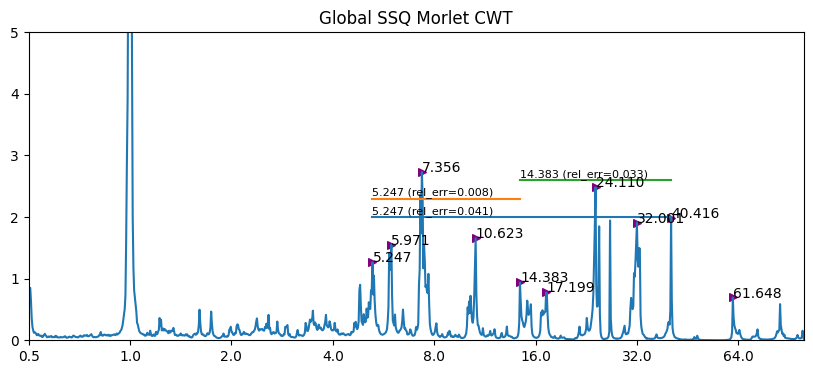

In [39]:
# %% Plot global spectra
dt=1/24
wav          = 'morlet'        # T&C uses Morlet
voices       = 128              # == `notes`
notes        = voices
max_scale    = 2               #   “maxscale” in T&C
scale_type   = 'log'           #   “scaling”  in T&C  ('log' | 'linear')
plot_2d      = True            #   “plotpower2d”
plotpower2d  = True

d2sec=24
x_days = [1/(60*d2sec), 1/(30*d2sec), 1/(15*d2sec), 1/(7.5*d2sec), 1/(4*d2sec), 1/(2*d2sec), 1/(d2sec), 1/(0.5*d2sec)]
x_days = 1/np.array(x_days)
x_days = list(x_days[::-1])

for subj in [8]:
    df = pd.read_csv('/content/multidien_modeling_utils/preprocessed_data_development_cohort/preprocessed_' + str(subj) + '.csv')

    if subj==15:
        signal_og = df.IEA.values
    else:
        signal_og = df.IEA_1.values

    N    = len(signal_og)
    time = np.arange(0, N) * dt
    t = time
    fs   = 1.0/np.mean(np.diff(t)) # sampling‑rate (Hz). 1 if t is index units
    scales = _setscales(N, 1, 128, 'log')

    # Wavelet transform the data
    wav        = Wavelet('morlet', N=N)                  # exposes wc
    Tx, Wx, ssq_freqs_c, scales_out, *_ = ssq_cwt(signal_og,
                    wavelet=wav,
                    scales=scales,              # our custom array
                    nv=voices,                  # still tell cwt “how dense”
                    fs=fs)                      # so frequencies are minted
    power        = np.abs(Tx)**2
    # scale_spectrum = power.sum(axis=1) / scales.squeeze() # for scaled spec
    scale_spectrum = power.sum(axis=1)
    scale_spectrum*=8
    scale_spectrum   = scale_spectrum[::-1]

    periods_days    = 1.0 / ssq_freqs_c[::-1]         # days

    # Plot peaks
    fig, (ax) = plt.subplots(1,1,figsize=(10,4))
    ax.plot(periods_days,scale_spectrum)

    peaks_ind2 = peakutils.indexes(np.log(scale_spectrum), thres=.8, min_dist=25)
    peaks_md = []
    for p in peaks_ind2:
        if periods_days[p] > 1 and periods_days[p]<65:
            ax.scatter(periods_days[p], scale_spectrum[p], s=30, marker='>', color='purple')
            ax.text(periods_days[p], scale_spectrum[p], f"{convertHz(periods_days[p]):.3f}", fontsize=10)
            peaks_md.append(convertHz(periods_days[p]))

    periods = np.array(peaks_md)
    period_array = (2*np.pi / wav.wc) * scales_out * dt

    ratio_mat, diag = efold_grid_diagnostics(
        peaks=periods,                # pass values, not indices
        period_array=period_array,
        notes=notes,
        max_k=3,                      # search e, e², e³
        rel_tol=0.05,                 # 5 % to call it an e‑fold
        grid_tol=0.05,                # 5 % to align to the grid
        assume_indices=False)

    # Plot e-fold pairs
    cmap = matplotlib.cm.get_cmap('tab10')
    color_cycle = [cmap(i % 10) for i in range(len(diag))]
    kk = 0.3
    for nrow, row in diag.iterrows():
        if row.i < row.j:
            ax.plot([row.period_i, row.period_j], [nrow*kk+2,nrow*kk+2], color=color_cycle[nrow])
            ax.text(row.period_j, nrow*kk+2.05, f"{row.period_j:.3f} (rel_err={row.rel_error:.3f})", fontsize=8)
    ax.set_xlim(0.5, 100)
    ax.set_xscale('log', base=2)
    ax.set_xticklabels([convertHz(xt) for xt in ax.get_xticks()]);
    ax.set_ylim(0,5)

    plt.title('Global SSQ Morlet CWT')
    if 0: #save
        out_fname = f"/content/data/global_peaks_sst/subj{subj}_cwt_global_peaks_sst.png"   # subj must exist
        fig.savefig(out_fname, dpi=300, bbox_inches='tight') # high‑res PNG
        print(f"Waterfall plot saved as {out_fname}")
        plt.close(fig)
    # ax.set_yscale('log')
    plt.show()

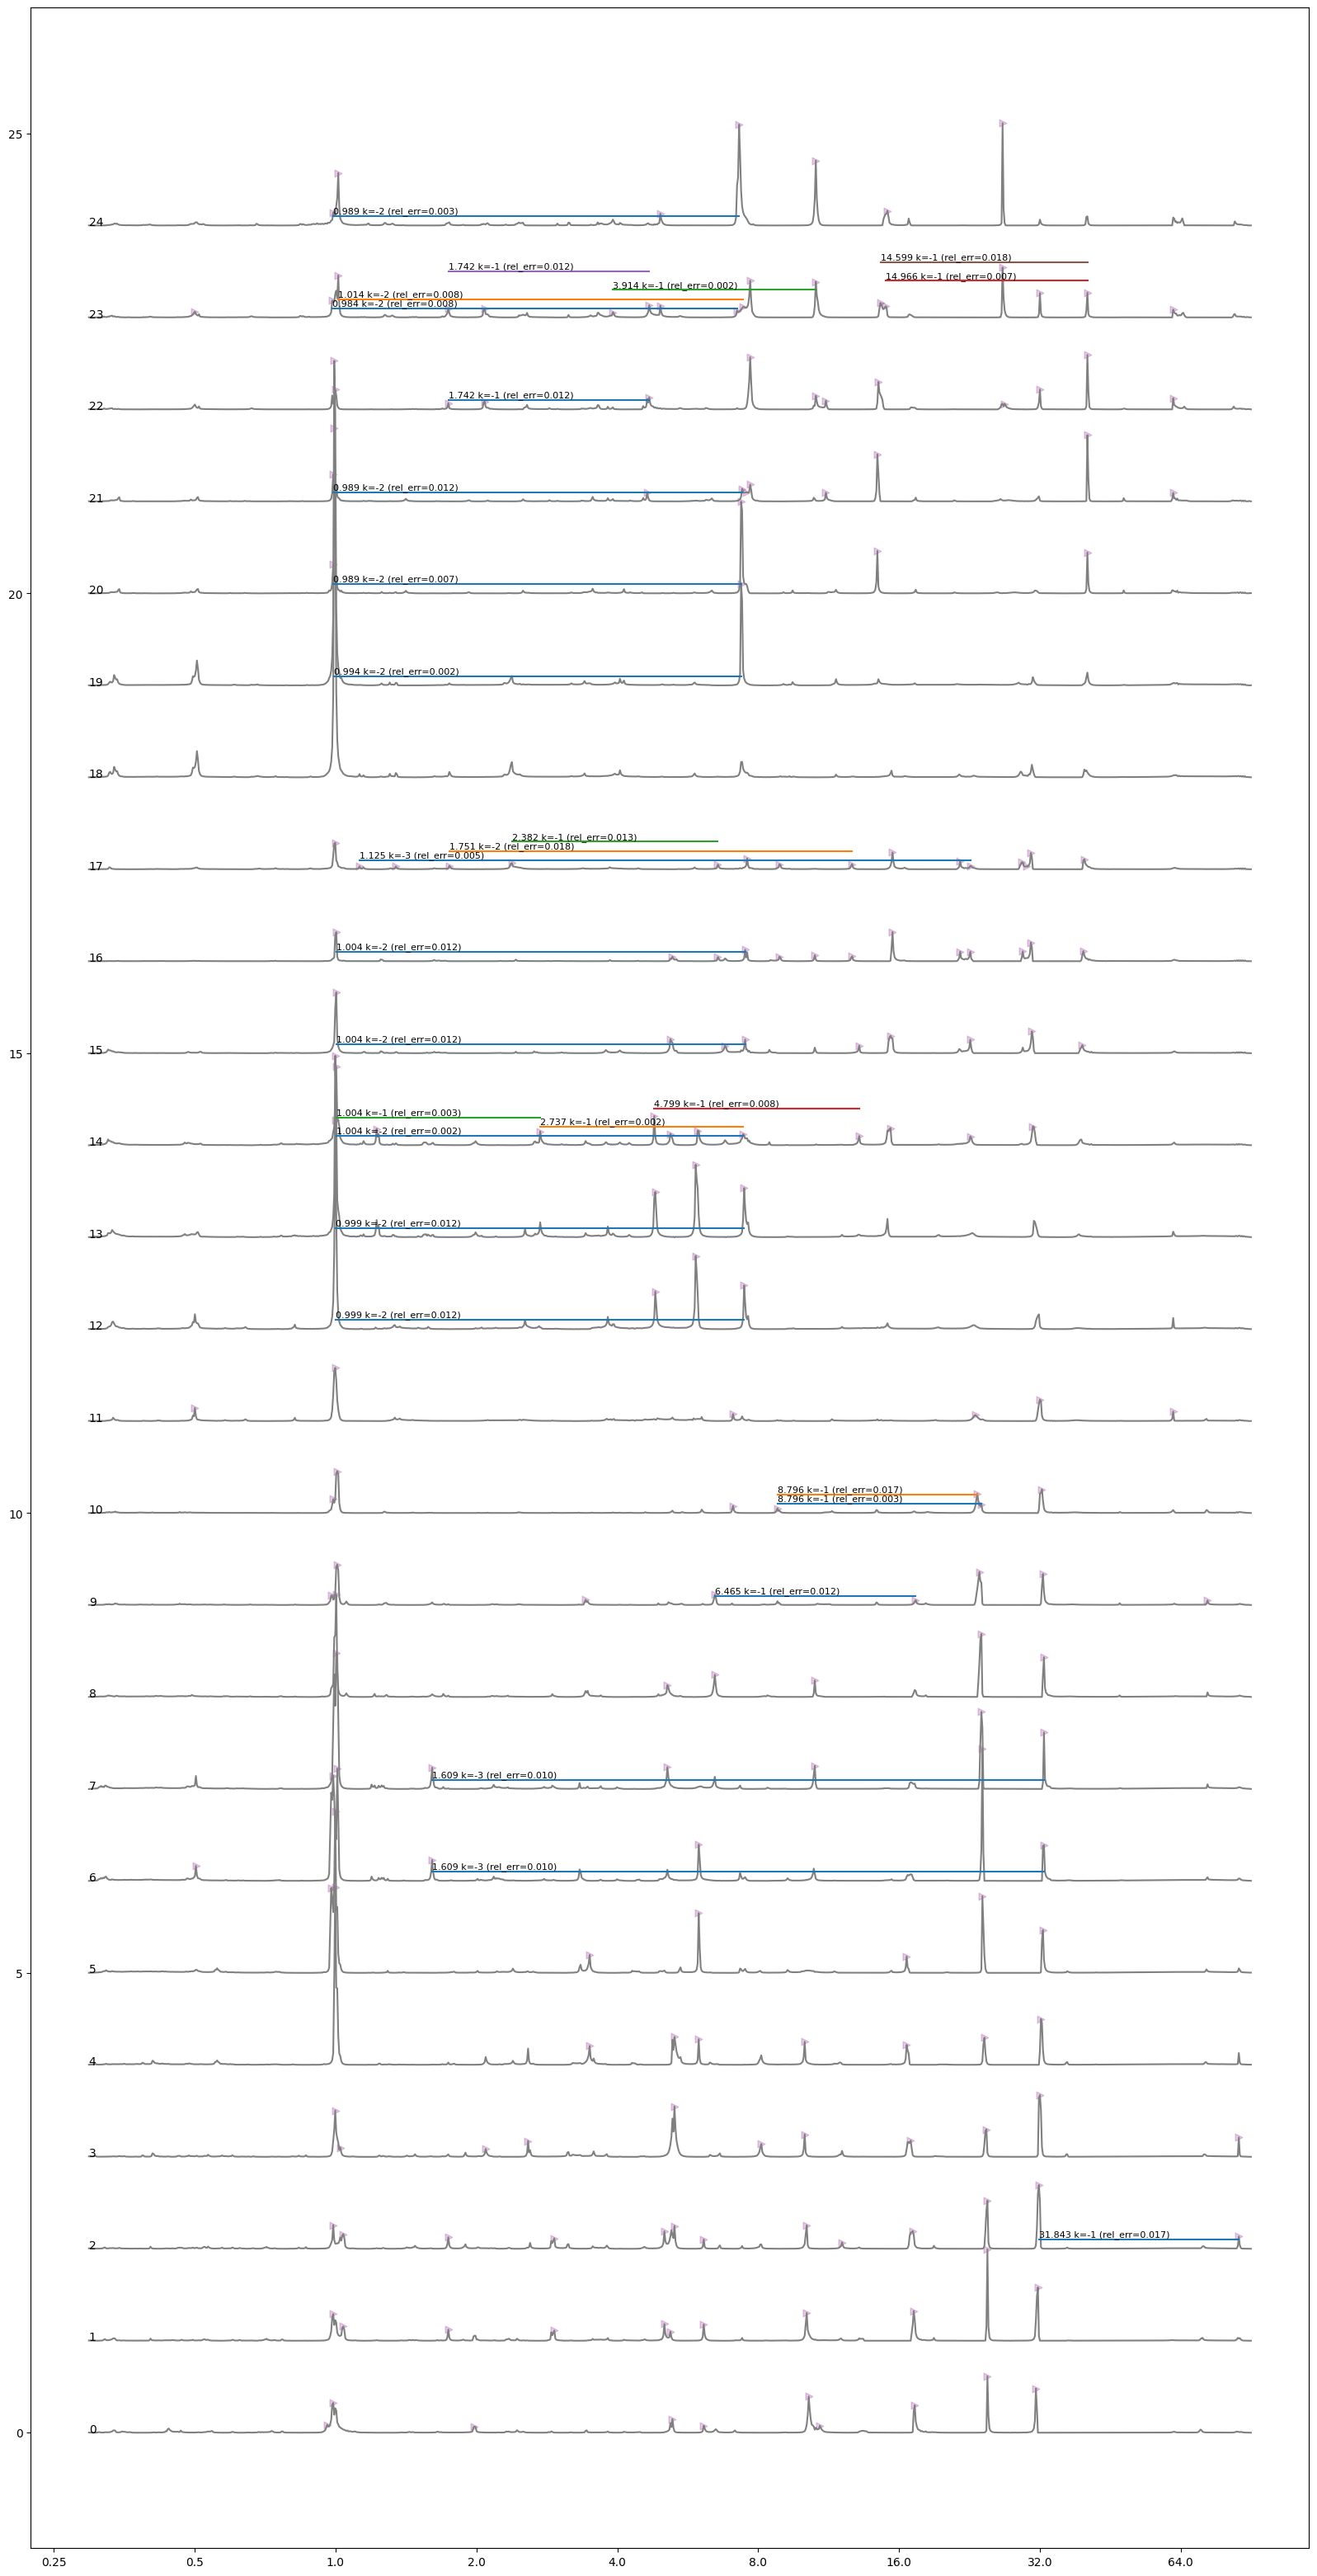

In [38]:
# Take current subject and do per-segment analysis
cmap = matplotlib.colormaps.get_cmap('tab10')

logmode = False
spacer = 1
scaler = 5
lengthChunk = 24 * 14  #* 10
lengthSlide = 24 * 14
numSegments = int(np.floor((len(time) - lengthChunk)/lengthSlide))
vara=1

fig,ax = plt.subplots(1,1,figsize=(20,40))

all_specs_idxs = []
all_specs_pds = []
for k in range(numSegments):
    pwr = getpower(Tx[:, lengthSlide*(k):lengthSlide*(k+1) + lengthChunk])
    scalespec=np.sum(pwr,axis=1)

    scalespec   = scalespec[::-1]
    xline     = 1.0 / ssq_freqs_c[::-1]      # days
    # Disregard noisy few indices
    scalespec = scalespec[128:-256]
    xline = xline[128:-256]

    if logmode:
        yline = np.log10(scalespec/vara+0.01)
    else:
        yline = scalespec/vara+0.01
        base = peakutils.baseline(yline, 9, max_it=10000)
        yline = yline - base

    ax.plot(xline, yline*scaler + k*spacer, 'gray')
    ax.text(np.min(xline), k, str(k))

    # Peak Finding
    peaks_ind = peakutils.indexes(scalespec, thres=0.1, min_dist=3)
    peaks_md = []
    peaks_md_pd = []
    for p in peaks_ind:
        ax.scatter(xline[p], yline[p]*scaler + spacer*k, s=40, marker='>', color='purple', alpha=0.2)
        pd_val = convertHz(xline[p])
        peaks_md.append(p)
        peaks_md_pd.append(pd_val)

    periods = np.array(peaks_md_pd)
    period_array = (2*np.pi / wav.wc) * scales_out * dt

    ratio_mat, diag = efold_grid_diagnostics(
        peaks=periods,                # pass values, not indices
        period_array=period_array,
        notes=notes,
        max_k=3,                      # search e, e², e³
        rel_tol=0.02,                 # 2 % to call it an e‑fold
        grid_tol=0.05,                # 5 % to blame the grid
        assume_indices=False)

    # Plot e-fold pairs
    color_cycle = [cmap(i % 10) for i in range(len(diag))]
    kk = 0.1
    for nrow, row in diag.iterrows():
        if row.i < row.j:
            ax.plot([row.period_i, row.period_j], [k+nrow*kk+0.1, k+nrow*kk+0.1], color=color_cycle[nrow])
            ax.text(row.period_j, k+nrow*kk+0.13, f"{row.period_j:.3f} k={row.k} (rel_err={row.rel_error:.3f})", fontsize=8)

    all_specs_idxs.append(peaks_md)
    all_specs_pds.append(peaks_md_pd)


ax.set_xscale('log', base=2)
ax.set_xticklabels([convertHz(xt) for xt in ax.get_xticks()]);

plt.show()